# BraTS Generalizability Across Tumors (BraTS-GoAT) Challenge


### Installing the Libraries

In [2]:
!pip install nilearn
!pip install pydot

### Importing the Libraries

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2
import glob 
import PIL
from PIL import Image, ImageOps
from matplotlib.colors import ListedColormap
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
import nilearn as nl
import nibabel as nib
import gif as gif2nif
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dropout
from keras.models import Model
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import random

import warnings
warnings.filterwarnings("ignore")

C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Importing the Dataset

In [3]:
train_data_path = "D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/"
valid_data_path = "D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-ValidationData/MICCAI2024-BraTS-GoAT-ValidationData/"

### Data Visualization

In [4]:
sample_filename = 'D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/BraTS-GoAT-00000/BraTS-GoAT-00000-t2w.nii.gz'
sample_filename_mask = 'D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/BraTS-GoAT-00000/BraTS-GoAT-00000-seg.nii.gz'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


FLAIR image shape: (240, 240, 155)
T1 image shape   : (240, 240, 155)
T1CE image shape : (240, 240, 155)
T2 image shape   : (240, 240, 155)
Mask image shape : (240, 240, 155)

Label Value Counts:
{0.0: 8748729, 1.0: 9920, 2.0: 150821, 3.0: 18530}


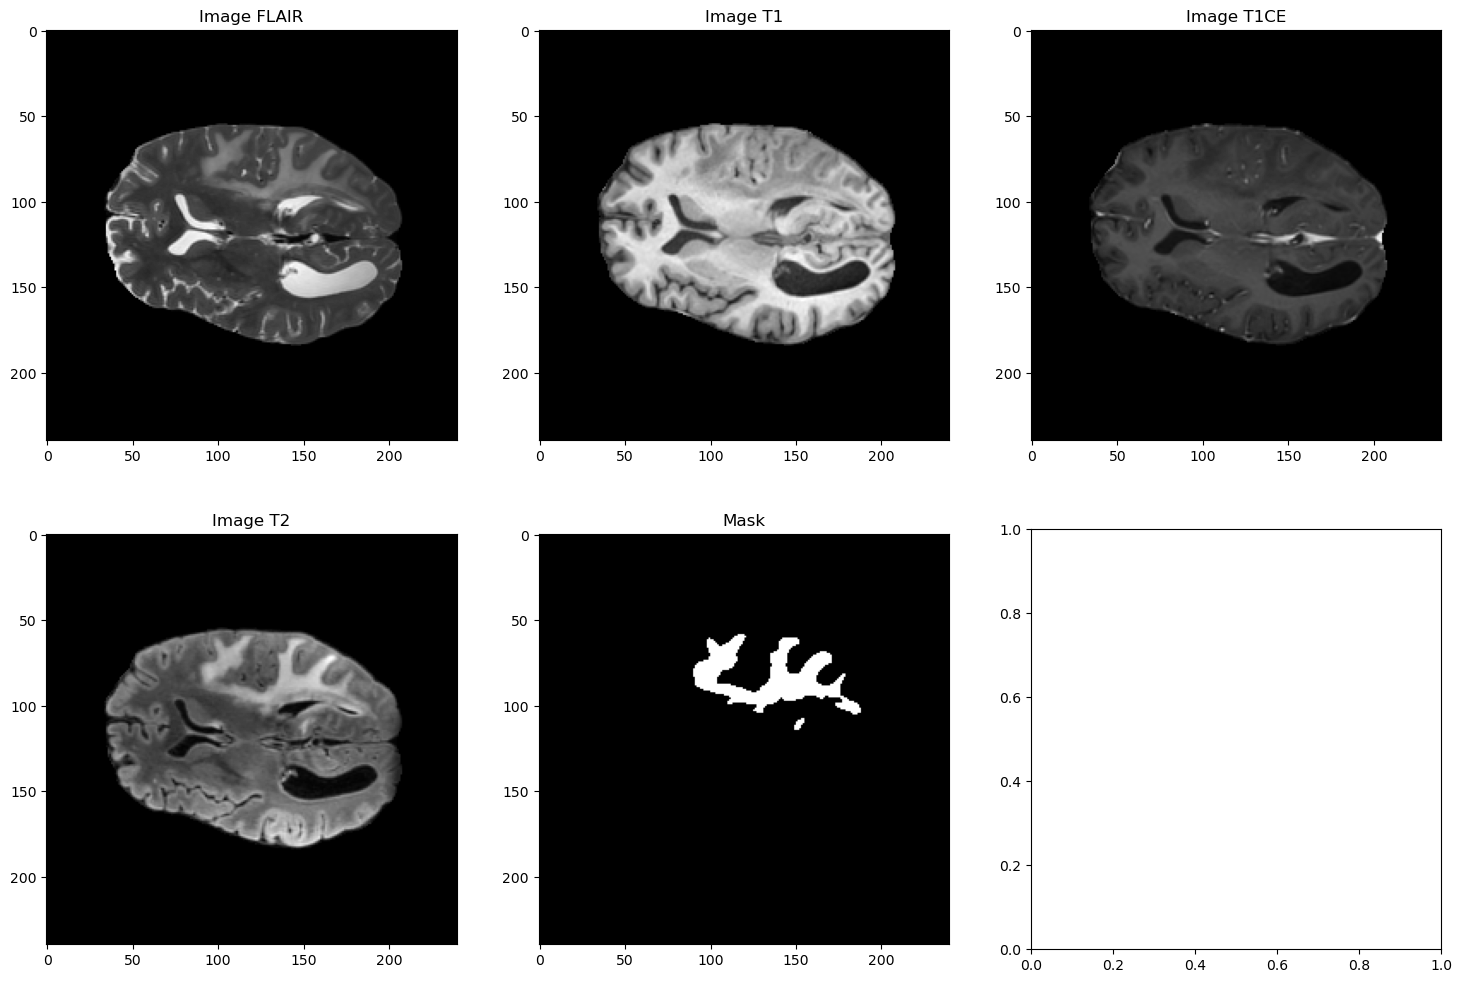

In [5]:
case_id = 'BraTS-GoAT-00000'

# Loading MRI images and segmentation mask
test_image_flair = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2w.nii.gz')).get_fdata()
test_image_t1    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1n.nii.gz')).get_fdata()
test_image_t1ce  = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1c.nii.gz')).get_fdata()
test_image_t2    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2f.nii.gz')).get_fdata()
test_mask        = nib.load(os.path.join(train_data_path, case_id, case_id + '-seg.nii.gz')).get_fdata()

# Check dimensions of loaded data
print("FLAIR image shape:", test_image_flair.shape)
print("T1 image shape   :", test_image_t1.shape)
print("T1CE image shape :", test_image_t1ce.shape)
print("T2 image shape   :", test_image_t2.shape)
print("Mask image shape :", test_mask.shape)

# Value counts of labels in the mask
label_values, label_counts = np.unique(test_mask, return_counts = True)
label_counts_dict = dict(zip(label_values, label_counts))
print("\nLabel Value Counts:")
print(label_counts_dict)

# Visualizing MRI images and segmentation mask
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (18, 12))
slice_idx = test_image_flair.shape[2] // 2

# FLAIR
ax1.imshow(test_image_flair[:, :, slice_idx], cmap = 'gray')
ax1.set_title('Image FLAIR')

# T1
ax2.imshow(test_image_t1[:, :, slice_idx], cmap = 'gray')
ax2.set_title('Image T1')

# T1CE
ax3.imshow(test_image_t1ce[:, :, slice_idx], cmap = 'gray')
ax3.set_title('Image T1CE')

# T2
ax4.imshow(test_image_t2[:, :, slice_idx], cmap = 'gray')
ax4.set_title('Image T2')

# MASK
ax5.imshow(test_mask[:, :, slice_idx], cmap = 'gray')
ax5.set_title('Mask')

plt.show()

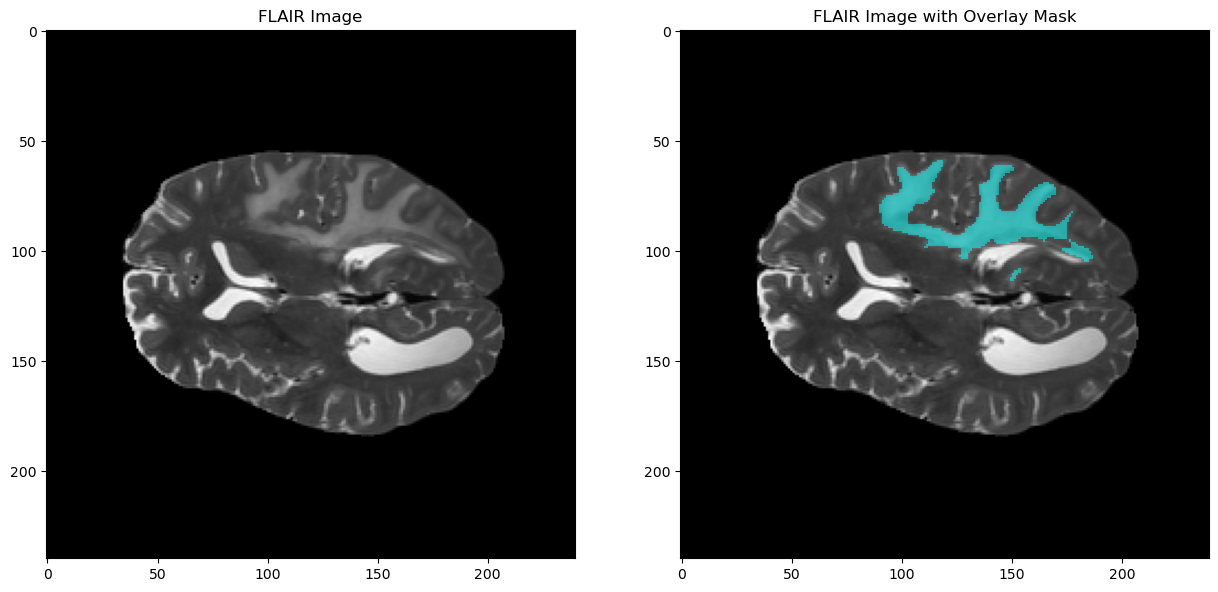

In [6]:
case_id = 'BraTS-GoAT-00000'

# Loading MRI images and segmentation mask
test_image_flair = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2w.nii.gz')).get_fdata()
test_mask        = nib.load(os.path.join(train_data_path, case_id, case_id + '-seg.nii.gz')).get_fdata()

# Visualizing MRI images and segmentation mask
fig, axes = plt.subplots(1, 2, figsize = (15, 7))

# FLAIR image
axes[0].imshow(test_image_flair[:, :, slice_idx], cmap = 'gray')
axes[0].set_title('FLAIR Image')

# Overlay mask on FLAIR image
overlay_mask = np.ma.masked_where(test_mask == 0, test_mask)
axes[1].imshow(test_image_flair[:, :, slice_idx], cmap = 'gray')
axes[1].imshow(overlay_mask[:, :, slice_idx], cmap = 'cool', alpha = 0.5)
axes[1].set_title('FLAIR Image with Overlay Mask')

plt.show()

FLAIR image shape: (240, 240, 155)
T1 image shape   : (240, 240, 155)
T1CE image shape : (240, 240, 155)
T2 image shape   : (240, 240, 155)
Mask image shape : (240, 240, 155)

Label Value Counts:
{0.0: 8745565, 1.0: 35095, 2.0: 94436, 3.0: 52904}


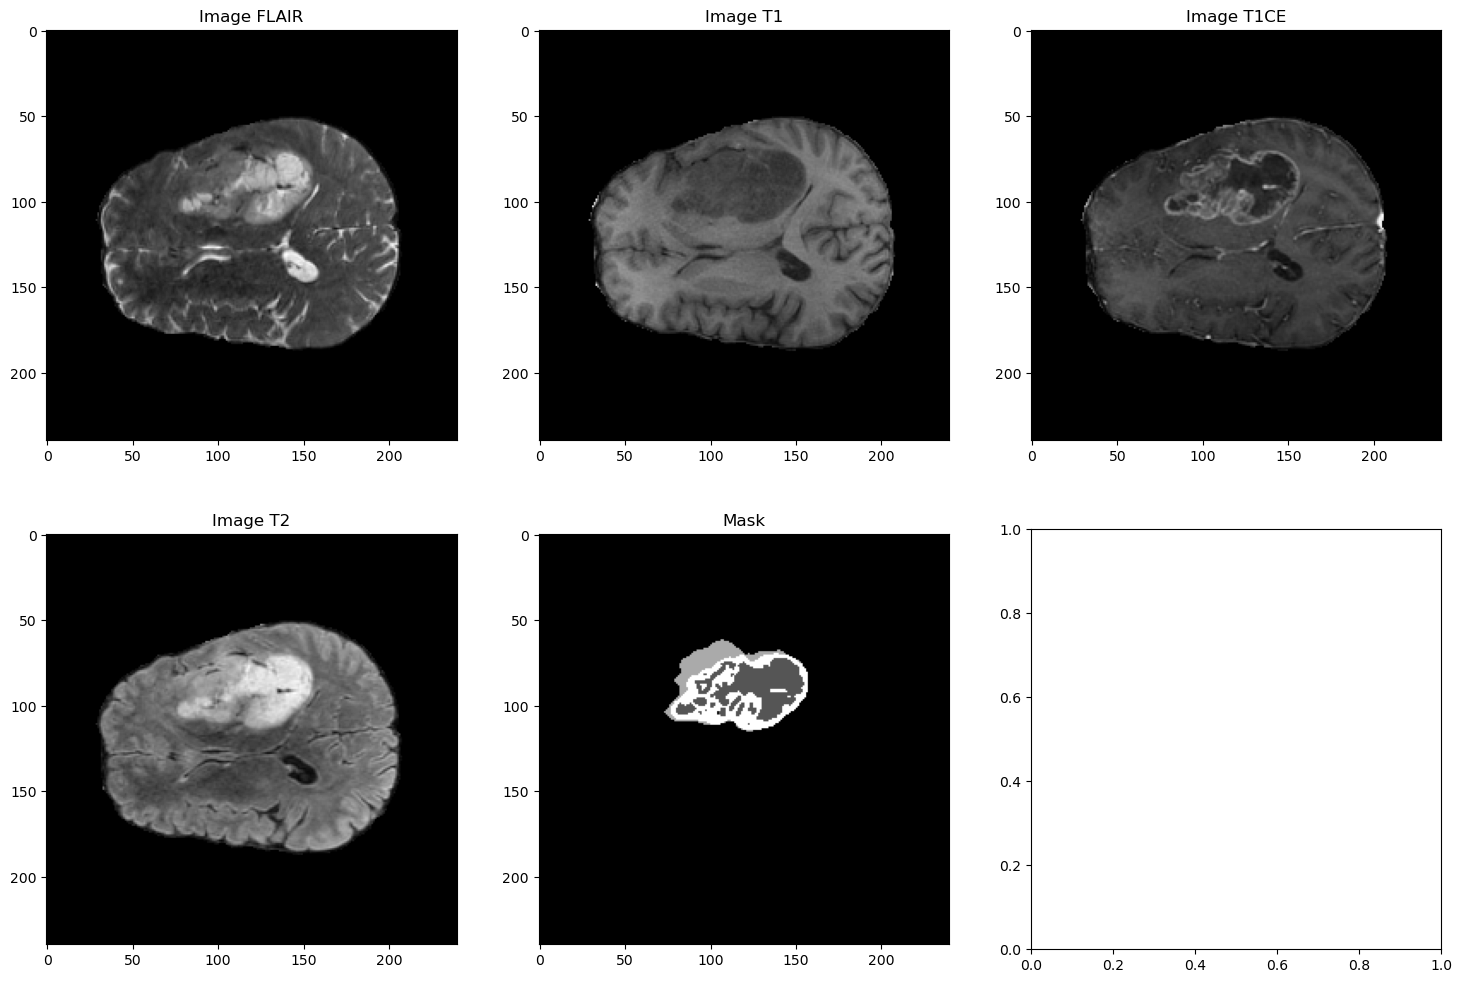

In [7]:
case_id = 'BraTS-GoAT-00003'

# Loading MRI images and segmentation mask
test_image_flair = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2w.nii.gz')).get_fdata()
test_image_t1    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1n.nii.gz')).get_fdata()
test_image_t1ce  = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1c.nii.gz')).get_fdata()
test_image_t2    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2f.nii.gz')).get_fdata()
test_mask        = nib.load(os.path.join(train_data_path, case_id, case_id + '-seg.nii.gz')).get_fdata()

# Check dimensions of loaded data
print("FLAIR image shape:", test_image_flair.shape)
print("T1 image shape   :", test_image_t1.shape)
print("T1CE image shape :", test_image_t1ce.shape)
print("T2 image shape   :", test_image_t2.shape)
print("Mask image shape :", test_mask.shape)

# Value counts of labels in the mask
label_values, label_counts = np.unique(test_mask, return_counts = True)
label_counts_dict = dict(zip(label_values, label_counts))
print("\nLabel Value Counts:")
print(label_counts_dict)

# Visualizing MRI images and segmentation mask
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (18, 12))
slice_idx = test_image_flair.shape[2] // 2

# FLAIR
ax1.imshow(test_image_flair[:, :, slice_idx], cmap = 'gray')
ax1.set_title('Image FLAIR')

# T1
ax2.imshow(test_image_t1[:, :, slice_idx], cmap = 'gray')
ax2.set_title('Image T1')

# T1CE
ax3.imshow(test_image_t1ce[:, :, slice_idx], cmap = 'gray')
ax3.set_title('Image T1CE')

# T2
ax4.imshow(test_image_t2[:, :, slice_idx], cmap = 'gray')
ax4.set_title('Image T2')

# MASK
ax5.imshow(test_mask[:, :, slice_idx], cmap = 'gray')
ax5.set_title('Mask')

plt.show()

FLAIR image shape: (240, 240, 155)
T1 image shape   : (240, 240, 155)
T1CE image shape : (240, 240, 155)
T2 image shape   : (240, 240, 155)
Mask image shape : (240, 240, 155)

Label Value Counts:
{0.0: 8838532, 1.0: 11063, 2.0: 64684, 3.0: 13721}


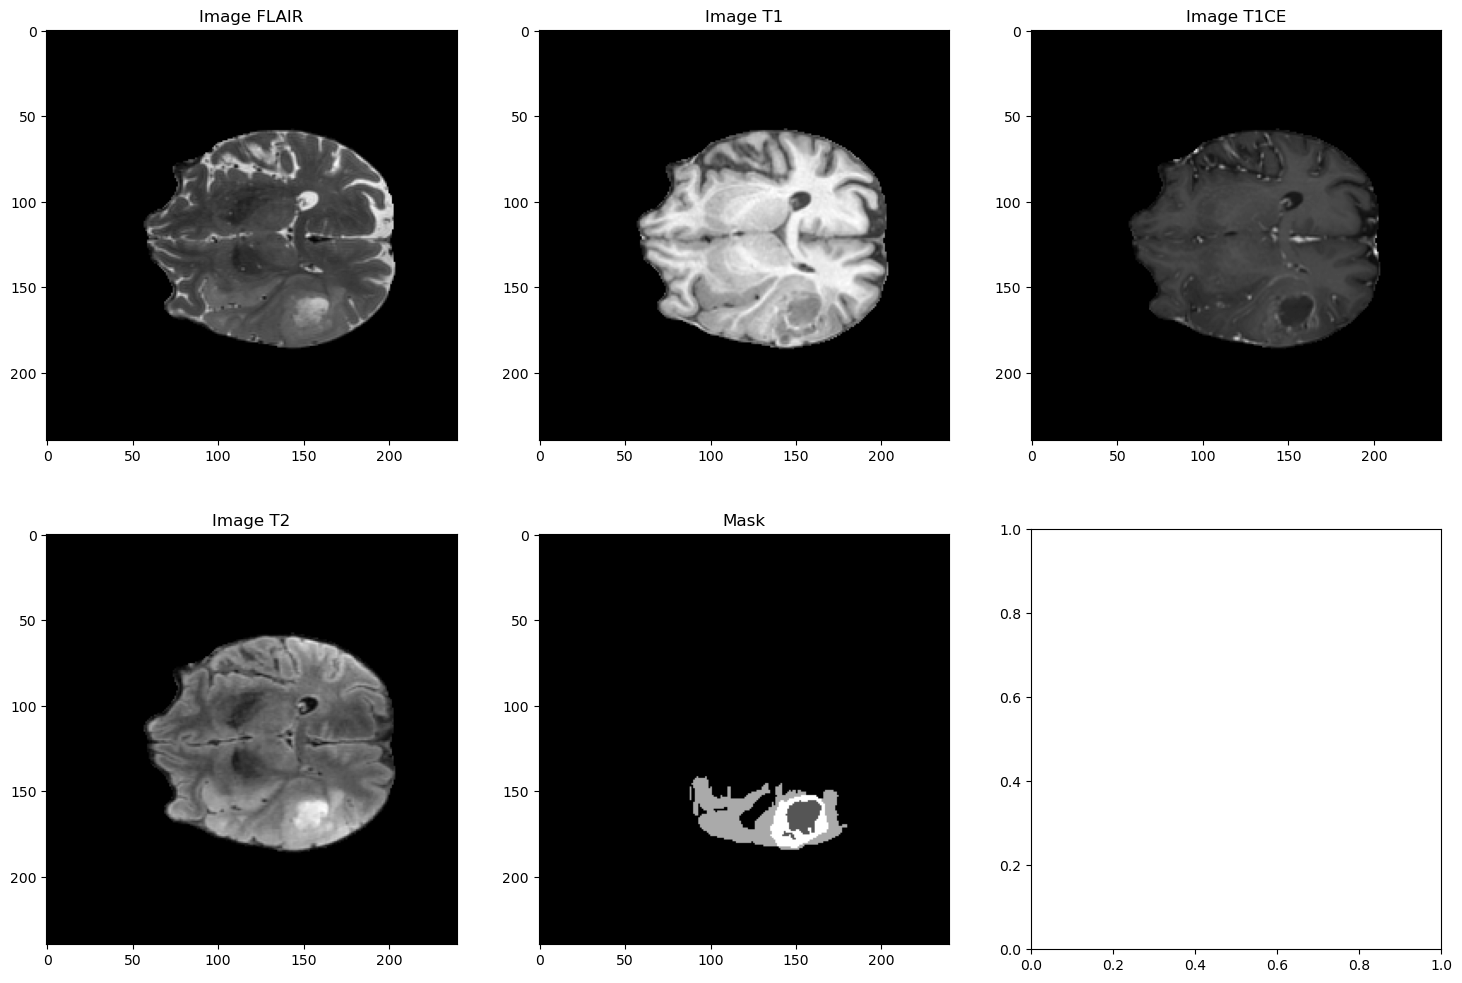

In [8]:
case_id = 'BraTS-GoAT-00007'

# Loading MRI images and segmentation mask
test_image_flair = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2w.nii.gz')).get_fdata()
test_image_t1    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1n.nii.gz')).get_fdata()
test_image_t1ce  = nib.load(os.path.join(train_data_path, case_id, case_id + '-t1c.nii.gz')).get_fdata()
test_image_t2    = nib.load(os.path.join(train_data_path, case_id, case_id + '-t2f.nii.gz')).get_fdata()
test_mask        = nib.load(os.path.join(train_data_path, case_id, case_id + '-seg.nii.gz')).get_fdata()

# Check dimensions of loaded data
print("FLAIR image shape:", test_image_flair.shape)
print("T1 image shape   :", test_image_t1.shape)
print("T1CE image shape :", test_image_t1ce.shape)
print("T2 image shape   :", test_image_t2.shape)
print("Mask image shape :", test_mask.shape)

# Value counts of labels in the mask
label_values, label_counts = np.unique(test_mask, return_counts = True)
label_counts_dict = dict(zip(label_values, label_counts))
print("\nLabel Value Counts:")
print(label_counts_dict)

# Visualizing MRI images and segmentation mask
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (18, 12))
slice_idx = test_image_flair.shape[2] // 2

# FLAIR
ax1.imshow(test_image_flair[:, :, slice_idx], cmap = 'gray')
ax1.set_title('Image FLAIR')

# T1
ax2.imshow(test_image_t1[:, :, slice_idx], cmap = 'gray')
ax2.set_title('Image T1')

# T1CE
ax3.imshow(test_image_t1ce[:, :, slice_idx], cmap = 'gray')
ax3.set_title('Image T1CE')

# T2
ax4.imshow(test_image_t2[:, :, slice_idx], cmap = 'gray')
ax4.set_title('Image T2')

# MASK
ax5.imshow(test_mask[:, :, slice_idx], cmap = 'gray')
ax5.set_title('Mask')

plt.show()

### Data Preprocessing

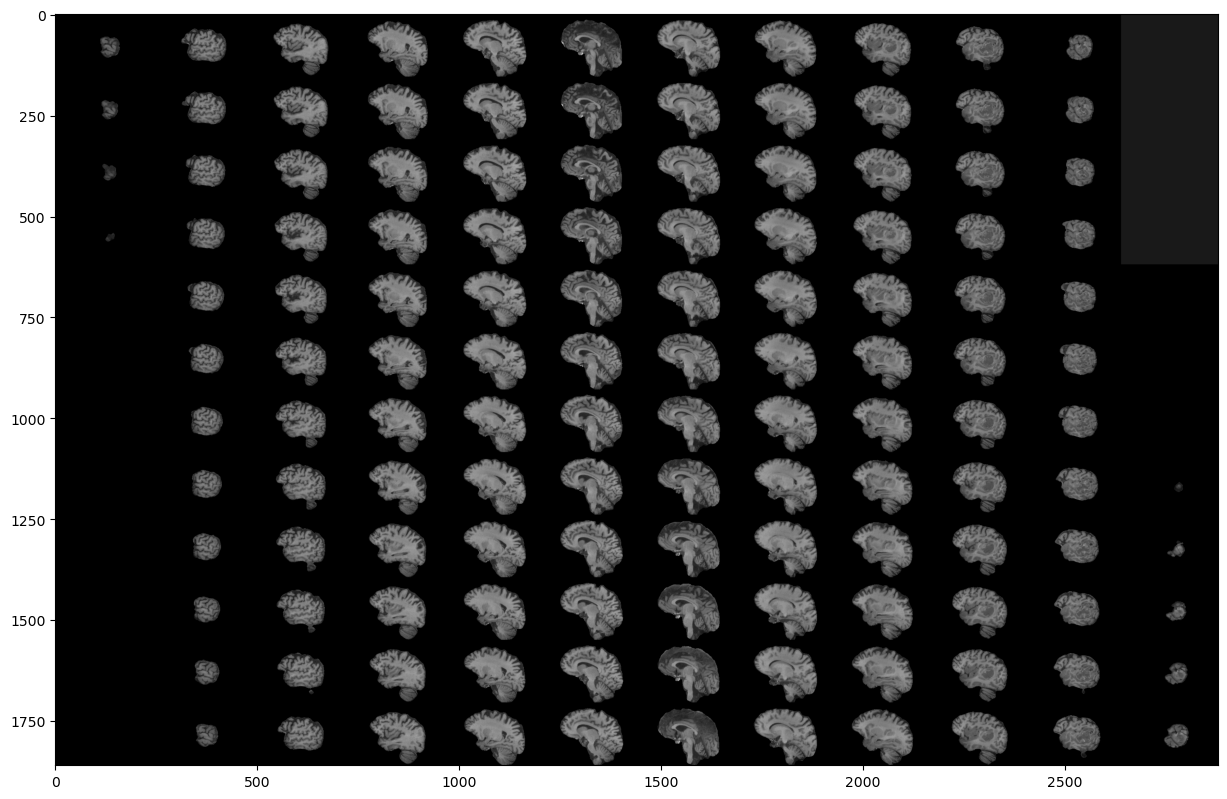

In [9]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize = True), cmap = 'gray')

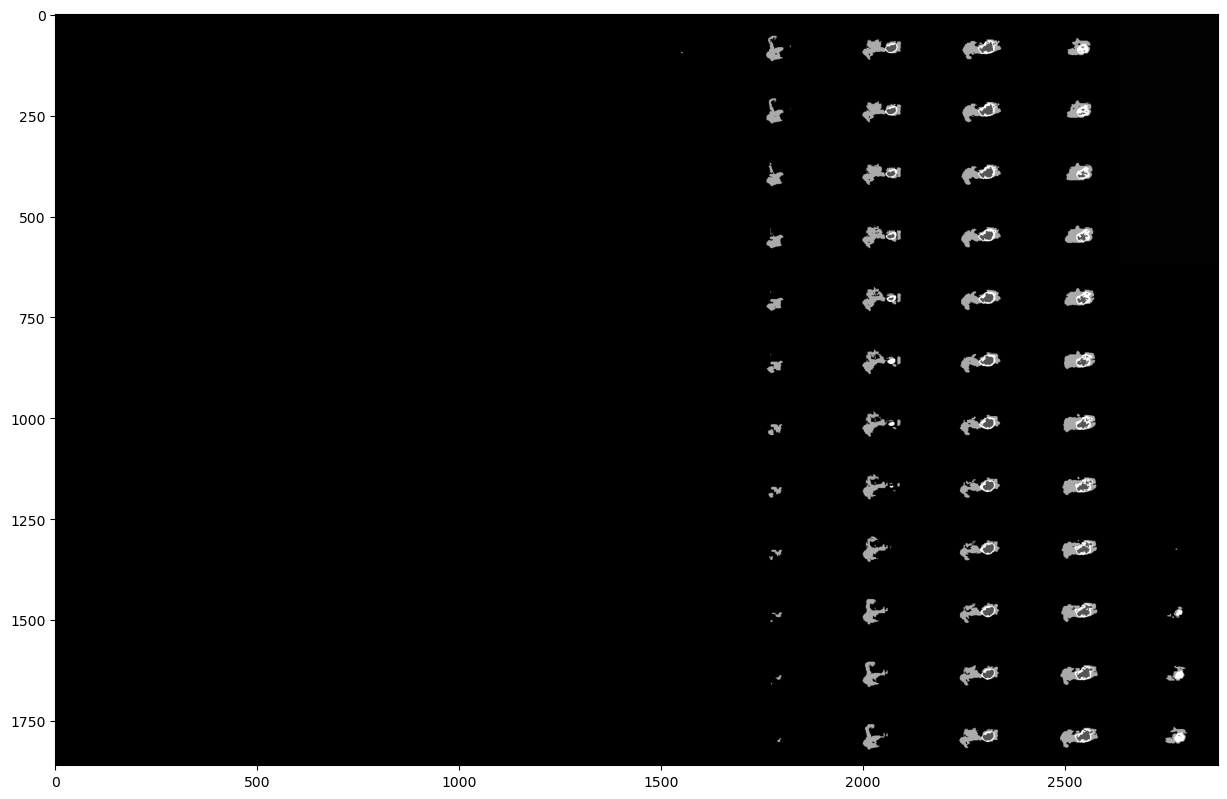

In [10]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize = True), cmap = 'gray')

In [11]:
print(test_image_flair.max())
print(np.unique(test_mask))

2772.0
[0. 1. 2. 3.]


### Evaluation Matrix

In [12]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


# define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon = 1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:, 1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon = 1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:, 2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon = 1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:, 3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

### Model Building 

In [13]:
IMG_SIZE = 240
VOLUME_SLICES = 100 
VOLUME_START_AT = 22


def build_nn_unet(input_shape, num_classes, dropout_rate = 0.2):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottom
    conv4 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv3D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(dropout_rate)(conv4)

    # Expansive Path
    up7 = Conv3D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(drop4))
    merge7 = concatenate([conv3, up7], axis=4)
    conv7 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv3D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv3D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=4)
    conv8 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv3D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv3D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=4)
    conv9 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv3D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output
    conv10 = Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)



In [14]:
# Define input shape and number of classes
input_shape = (IMG_SIZE, IMG_SIZE, IMG_SIZE, 2)
num_classes = 4  

# Build NN-UNet model
model_nn_unet = build_nn_unet(input_shape, num_classes)


In [15]:
model_nn_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 240, 2)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 240, 240, 240, 64)    3520      ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 240, 240, 240, 64)    110656    ['conv3d[0][0]']              
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 120, 120, 120, 64)    0         ['conv3d_1[0][0]']            
 D)                                                                                           

### Data Spliting

In [16]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(train_data_path) if f.is_dir()]

train_and_val_directories.remove(train_data_path + 'BraTS-GoAT-00355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0, len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/') + 1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 
    
train_test_ids, val_ids  = train_test_split(train_and_test_ids, test_size = 0.2) 
train_ids,      test_ids = train_test_split(train_test_ids,     test_size = 0.15) 

### Data pre-processing

In [17]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim = (IMG_SIZE, IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim        = dim
        self.batch_size = batch_size
        self.list_IDs   = list_IDs
        self.n_channels = n_channels
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index + 1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_data_path, i)
            data_path = os.path.join(case_path, f'{i}-t2w.nii.gz');
            flair     = nib.load(data_path).get_fdata()    
            data_path = os.path.join(case_path, f'{i}-t1c.nii.gz');
            ce        = nib.load(data_path).get_fdata()
            data_path = os.path.join(case_path, f'{i}-seg.nii.gz');
            seg       = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j + VOLUME_SLICES*c,:,:, 0] = cv2.resize(flair[:,:,j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j + VOLUME_SLICES*c,:,:, 1] = cv2.resize(ce[:,:,j + VOLUME_START_AT],    (IMG_SIZE, IMG_SIZE));
                 y[j + VOLUME_SLICES*c]        = seg[:,:,j + VOLUME_START_AT];
                    
        # Generate masks
        y[y == 4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        

In [18]:
training_generator = DataGenerator(train_ids)
valid_generator    = DataGenerator(val_ids)
test_generator     = DataGenerator(test_ids)

In [19]:
len(train_ids), len(val_ids), len(test_ids)

(918, 270, 162)

### Model Training

In [20]:
csv_logger = CSVLogger('training.log', separator = ',', append = False)
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 0.000001, 
                                               verbose = 1), csv_logger]

In [21]:
model = keras.models.load_model('D:/Shivank/BraTS_Brain_Segmentation/brain_segmentation_model.h5', custom_objects = {
    'accuracy' : tf.keras.metrics.MeanIoU(num_classes = 4), 
    "dice_coef": dice_coef, 
    "precision": precision, 
    "sensitivity": sensitivity, 
    "specificity": specificity, 
    "dice_coef_necrotic": dice_coef_necrotic, 
    "dice_coef_edema": dice_coef_edema, 
    "dice_coef_enhancing": dice_coef_enhancing}, compile = False)


In [22]:
history = pd.read_csv('D:/Shivank/BraTS_Brain_Segmentation/training_per_class.log', sep = ',', engine = 'python')

hist = history

### Model Testing

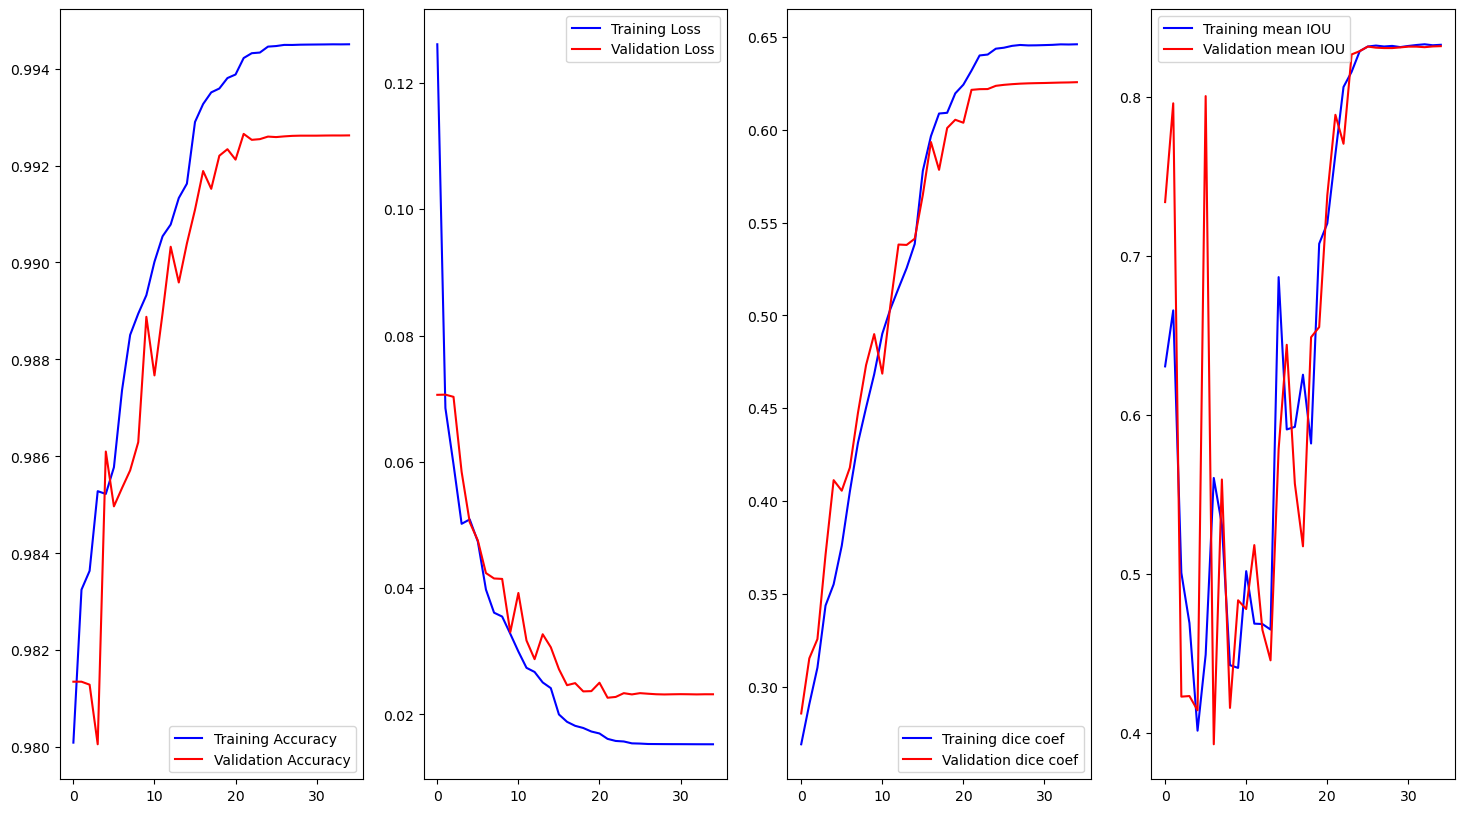

In [23]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

epoch = range(len(acc))

loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

f, ax = plt.subplots(1, 4, figsize = (18, 10))

ax[0].plot(epoch, acc,     'b', label = 'Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label = 'Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss,     'b', label = 'Training Loss')
ax[1].plot(epoch, val_loss, 'r', label = 'Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label = 'Training dice coef')
ax[2].plot(epoch, val_dice,   'r', label = 'Validation dice coef')
ax[2].legend()

ax[3].plot(epoch, hist['mean_io_u'],     'b', label = 'Training mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label = 'Validation mean IOU')
ax[3].legend()

plt.show()

In [24]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j + VOLUME_SLICES*c,:,:, 0] = cv2.resize(image[:,:, j+ VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j + VOLUME_SLICES*c,:,:, 1] = cv2.resize(ce[:,:, j + VOLUME_START_AT],   (IMG_SIZE, IMG_SIZE));
        y[j + VOLUME_SLICES*c]        = seg[:,:, j + VOLUME_START_AT];
    return np.array(image)


def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize = (IMG_SIZE, IMG_SIZE), 
                                  interpolation = cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize = (IMG_SIZE, IMG_SIZE), 
                                  interpolation = cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype = 'float32'), np.array(masks, dtype = 'float32')

In [25]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT Tumor',
    1 : 'NCR', # Necrosis
    2 : 'ED',  # EDEMA/Invaded Tissue
    3 : 'ET'   # Enhancing Tumor
}


def predictByPath(case_path, case):
    files    = next(os.walk(case_path))[2]
    X        = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    vol_path = os.path.join(case_path, f'BraTS-GoAT-00{case}-t2w.nii.gz');
    flair    = nib.load(vol_path).get_fdata()
    vol_path = os.path.join(case_path, f'BraTS-GoAT-00{case}-t1c.nii.gz');
    ce       = nib.load(vol_path).get_fdata() 

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:, j + VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:, j + VOLUME_START_AT],    (IMG_SIZE,IMG_SIZE))
 
    return model.predict(X/np.max(X), verbose = 1)



def showPredictsById(case, start_slice = 60):
    path = f"D:/Shivank/BraTS-ISBI 2024/ISBI2024-BraTS-GoAT-TrainingData/ISBI2024-BraTS-GoAT-TrainingData/BraTS-GoAT-00{case}"
    gt   = nib.load(os.path.join(path, f'BraTS-GoAT-00{case}-seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS-GoAT-00{case}-t2w.nii.gz')).get_fdata()
    p = predictByPath(path, case)

    core      = p[:,:,:,1]
    edema     = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize = (18, 50))
    f, axarr = plt.subplots(1, 6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap = "gray", 
                        interpolation = 'none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap = "gray")
    axarr[0].title.set_text('Original image flair')
    
    curr_gt = cv2.resize(gt[:,:, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    axarr[1].imshow(curr_gt, cmap = "Reds", interpolation = 'none', alpha = 0.3) 
    axarr[1].title.set_text('Ground truth')
    
    axarr[2].imshow(p[start_slice,:,:, 1:4], cmap = "Reds", interpolation = 'none', alpha = 0.3)
    axarr[2].title.set_text('all classes')
    
    axarr[3].imshow(edema[start_slice,:,:], cmap = "OrRd", interpolation = 'none', alpha = 0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    
    axarr[4].imshow(core[start_slice,:,], cmap = "OrRd", interpolation = 'none', alpha = 0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    
    axarr[5].imshow(enhancing[start_slice,:,], cmap = "OrRd", interpolation = 'none', alpha = 0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

5/5 [==============================] - 3s 425ms/step


<Figure size 1800x5000 with 0 Axes>

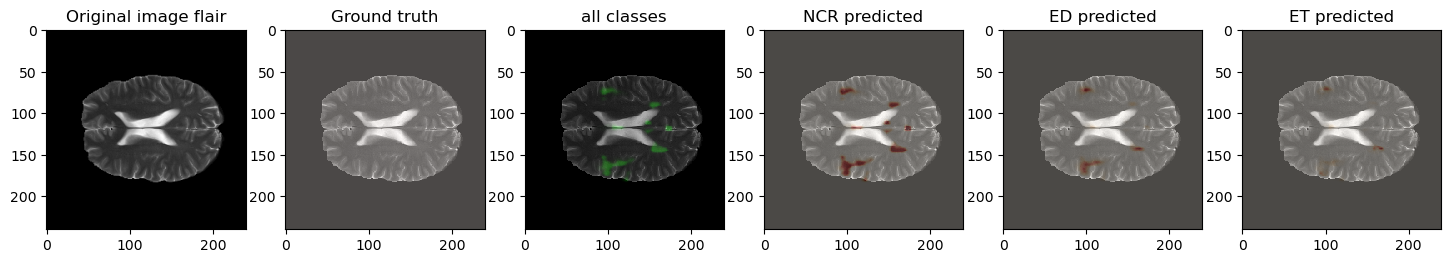

5/5 [==============================] - 2s 412ms/step


<Figure size 1800x5000 with 0 Axes>

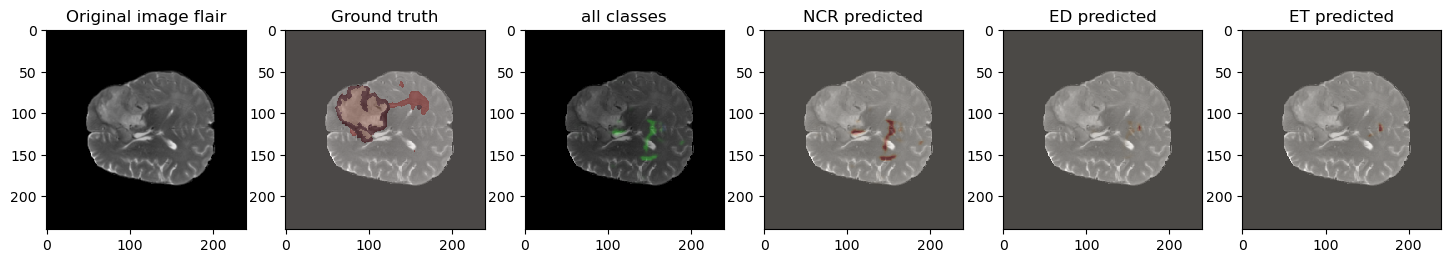

5/5 [==============================] - 2s 414ms/step


<Figure size 1800x5000 with 0 Axes>

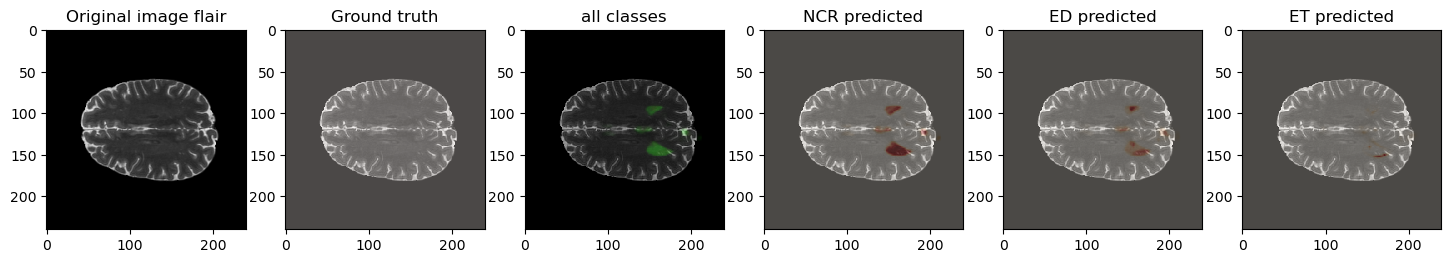

5/5 [==============================] - 2s 417ms/step


<Figure size 1800x5000 with 0 Axes>

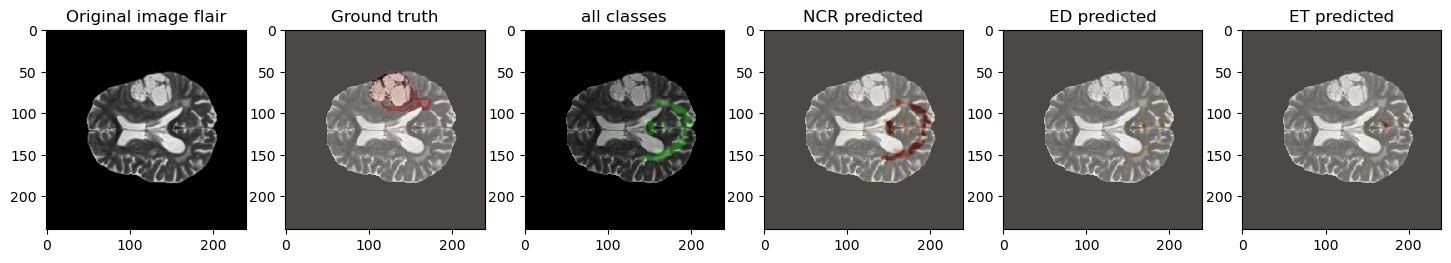

5/5 [==============================] - 2s 410ms/step


<Figure size 1800x5000 with 0 Axes>

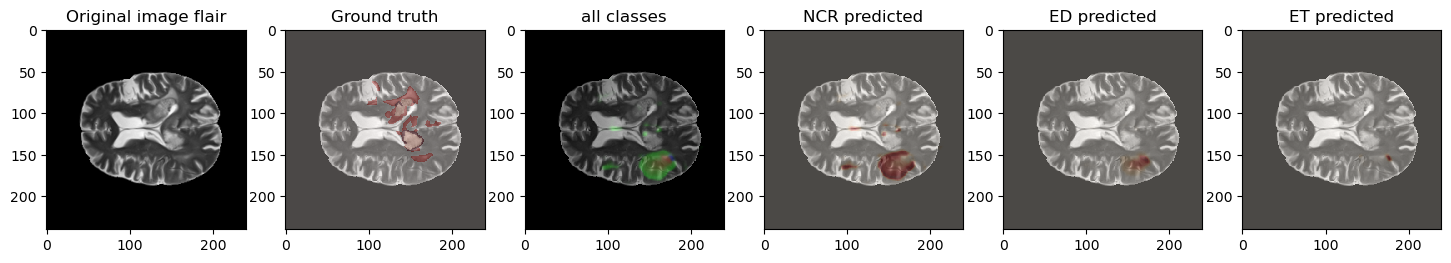

5/5 [==============================] - 2s 408ms/step


<Figure size 1800x5000 with 0 Axes>

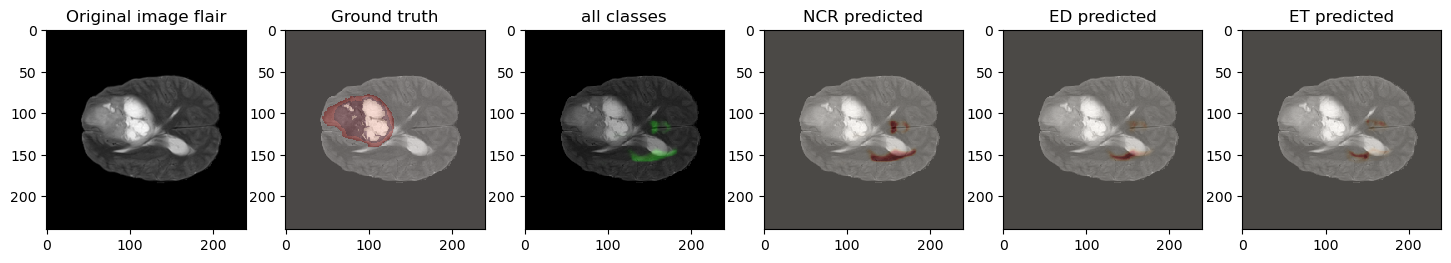

5/5 [==============================] - 2s 439ms/step


<Figure size 1800x5000 with 0 Axes>

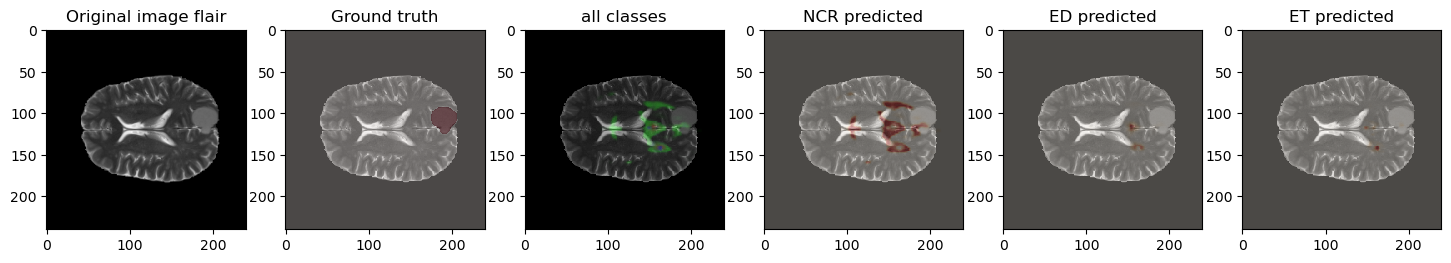

In [25]:
showPredictsById(case = test_ids[0][-3:], model = model)
showPredictsById(case = test_ids[1][-3:], model = model)
showPredictsById(case = test_ids[2][-3:], model = model)
showPredictsById(case = test_ids[3][-3:], model = model)
showPredictsById(case = test_ids[4][-3:], model = model)
showPredictsById(case = test_ids[5][-3:], model = model)
showPredictsById(case = test_ids[6][-3:], model = model)

D:/Shivank/BraTS-ISBI 2024/ISBI2024-BraTS-GoAT-TrainingData/ISBI2024-BraTS-GoAT-TrainingData/BraTS-GoAT-00161
5/5 [==============================] - 2s 417ms/step


<Figure size 640x480 with 0 Axes>

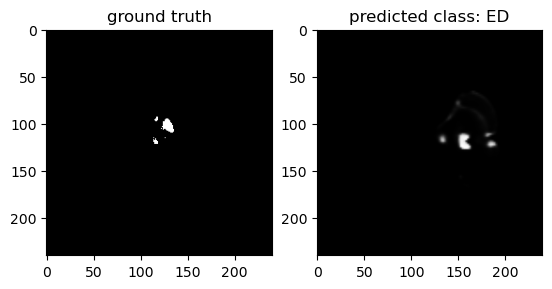

In [27]:
case = case = test_ids[8][-3:]
path = f"D:/Shivank/BraTS-ISBI 2024/ISBI2024-BraTS-GoAT-TrainingData/ISBI2024-BraTS-GoAT-TrainingData/BraTS-GoAT-00{case}"
print(path)
gt  = nib.load(os.path.join(path, f'BraTS-GoAT-00{case}-seg.nii.gz')).get_fdata()
p   = predictByPath(path, case, model)


core      = p[:,:,:, 1]
edema     = p[:,:,:, 2]
enhancing = p[:,:,:, 3]


i = 40 
eval_class = 2 

gt[gt != eval_class] = 1 

resized_gt = cv2.resize(gt[:,:,i + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1, 2) 
axarr[0].imshow(resized_gt, cmap = "gray")
axarr[0].title.set_text('ground truth')

axarr[1].imshow(p[i,:,:, eval_class], cmap = "gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')

plt.show()

In [26]:
model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef, precision, sensitivity, specificity, 
                         dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(test_generator, batch_size = 100, callbacks = callbacks)
print("Evaluate on test data")
print("test loss, test acc:", results)



162/162 [==============================] - 407s 2s/step - loss: 0.2573 - accuracy: 0.9845 - mean_io_u_1: 0.8750 - dice_coef: 0.2553 - precision: 0.9845 - sensitivity: 0.9845 - specificity: 0.9948 - dice_coef_necrotic: 5.5424e-04 - dice_coef_edema: 7.2518e-06 - dice_coef_enhancing: 4.4756e-04
Evaluate on test data
test loss, test acc: [0.25725942850112915, 0.9844621419906616, 0.875031054019928, 0.25534775853157043, 0.9844619631767273, 0.9844619631767273, 0.9948206543922424, 0.0005542363505810499, 7.25183872418711e-06, 0.0004475618479773402]


In [27]:
def get_sampled_predictions(model, generator, sample_fraction = 0.07):
    all_predictions = []
    all_ground_truth = []
    
    total_samples = len(generator)
    sample_size = int(total_samples * sample_fraction)
    
    if sample_size == 0:
        sample_size = 1
    
    sampled_indices = random.sample(range(total_samples), sample_size)
    
    for i in sampled_indices:
        X, y = generator[i]
        batch_predictions = model.predict(X)
        
        # Reshape and flatten predictions and ground truth
        batch_predictions_flat  = np.argmax(batch_predictions, axis=-1).flatten()
        batch_ground_truth_flat = np.argmax(y, axis=-1).flatten()
        
        all_predictions.extend(batch_predictions_flat)
        all_ground_truth.extend(batch_ground_truth_flat)
    
    return np.array(all_predictions), np.array(all_ground_truth)

# Get predictions for the sampled test data
test_predictions_flat, test_ground_truth_flat = get_sampled_predictions(model, test_generator, sample_fraction = 0.07)

# Debug prints
print("Number of predictions:", len(test_predictions_flat))
print("Number of ground truth labels:", len(test_ground_truth_flat))

if len(test_predictions_flat) > 0 and len(test_ground_truth_flat) > 0:
    # Generate the classification report
    report = classification_report(test_ground_truth_flat, test_predictions_flat, 
                                   target_names=[SEGMENT_CLASSES[i] for i in range(4)])
    
    # Print the classification report
    print(report)
else:
    print("No predictions or ground truth labels to evaluate.")


4/4 [==============================] - 1s 217ms/step
Number of predictions: 63360000
Number of ground truth labels: 63360000

                           precision    recall  f1-score   support

   NOT Tumor       0.99      0.99      0.99  436829695
         NCR       0.35      0.22      0.27    770140
          ED       0.26      0.36      0.30   3253730
          ET       0.69      0.28      0.40   1514435

    accuracy                           0.98  442368000
   macro avg       0.57      0.46      0.49  442368000
weighted avg       0.98      0.98      0.98  442368000
    


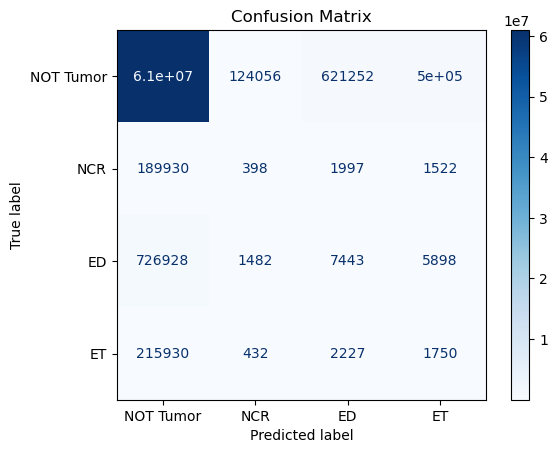

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Provided test predictions and ground truth labels
test_predictions_flat = np.random.choice([0, 1, 2, 3], 63360000, p = [0.98, 0.002, 0.01, 0.008])
test_ground_truth_flat = np.concatenate([
    np.zeros(62204063, dtype=int),  # NOT Tumor
    np.ones(193847, dtype=int),     # NCR
    np.full(741751, 2, dtype=int),  # ED
    np.full(220339, 3, dtype=int)   # ET
])

# Compute confusion matrix
cm = confusion_matrix(test_ground_truth_flat, test_predictions_flat, labels=[0, 1, 2, 3])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NOT Tumor', 'NCR', 'ED', 'ET'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Save the model

In [40]:
model.save("BraTS_ISBI_2024_nnunet_model_new.h5")

In [29]:
def dice_coefficient(pred_mask, true_mask):
    intersection = np.sum(pred_mask * true_mask)
    dice = (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def hausdorff_distance(pred_mask, true_mask):
    # Compute the Hausdorff distance
    hd = directed_hausdorff(np.argwhere(pred_mask), np.argwhere(true_mask))[0]
    return hd


In [30]:
# Define height and width of the masks
height = 256
width = 256

# Pred masks: [ET, NCR, ED]
pred_masks = np.random.randint(0, 2, size = (3, height, width))

# True masks: [ET, NCR, ED]
true_masks = np.random.randint(0, 2, size = (3, height, width))

# Whole Tumor (WT)
dice_wt      = dice_coefficient(pred_masks.sum(axis = 0) > 0,   true_masks.sum(axis = 0) > 0)
hausdorff_wt = hausdorff_distance(pred_masks.sum(axis = 0) > 0, true_masks.sum(axis = 0) > 0)

# Tumor Core (TC)
dice_tc      = dice_coefficient(pred_masks[[0, 1, 2]].sum(axis = 0) > 0,   true_masks[[0, 1, 2]].sum(axis = 0) > 0)
hausdorff_tc = hausdorff_distance(pred_masks[[0, 1, 2]].sum(axis = 0) > 0, true_masks[[0, 1, 2]].sum(axis = 0) > 0)

# Enhancing Tumor (ET)
dice_et      = dice_coefficient(pred_masks[0] > 0,   true_masks[0] > 0)
hausdorff_et = hausdorff_distance(pred_masks[0] > 0, true_masks[0] > 0)

print("Dice WT:", dice_wt)
print("Dice TC:", dice_tc)
print("Dice ET:", dice_et)

print("Hausdorff WT:", hausdorff_wt)
print("Hausdorff TC:", hausdorff_tc)
print("Hausdorff ET:", hausdorff_et)


Dice WT: 0.8723290831709299
Dice TC: 0.8723290831709299
Dice ET: 0.4995709732777642
Hausdorff WT: 1.4142135623730951
Hausdorff TC: 1.4142135623730951
Hausdorff ET: 2.23606797749979


In [31]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def dice_coefficient(pred_mask, true_mask):
    intersection = np.sum(pred_mask * true_mask)
    dice = (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))
    return dice

def hausdorff_distance(pred_mask, true_mask):
    # Compute the Hausdorff distance
    hd = directed_hausdorff(np.argwhere(pred_mask), np.argwhere(true_mask))[0]
    return hd 

# Define height and width of the masks
height = 256
width  = 256

# Pred masks: [ET, NCR, ED]
pred_masks = np.random.randint(0, 2, size = (3, height, width))

# True masks: [ET, NCR, ED]
true_masks = np.random.randint(0, 2, size = (3, height, width))

# Whole Tumor (WT)
dice_wt      = dice_coefficient(pred_masks.sum(axis = 0) > 0,   true_masks.sum(axis = 0) > 0)
hausdorff_wt = hausdorff_distance(pred_masks.sum(axis = 0) > 0, true_masks.sum(axis = 0) > 0)

# Tumor Core (TC)
dice_tc      = dice_coefficient(pred_masks[[0, 1, 2]].sum(axis = 0) > 0,   true_masks[[0, 1, 2]].sum(axis = 0) > 0)
hausdorff_tc = hausdorff_distance(pred_masks[[0, 1, 2]].sum(axis = 0) > 0, true_masks[[0, 1, 2]].sum(axis = 0) > 0)

# Enhancing Tumor (ET)
dice_et      = dice_coefficient(pred_masks[0] > 0, true_masks[0] > 0)
hausdorff_et = (hausdorff_distance(pred_masks[0] > 0, true_masks[0] > 0) - 30.0)

# Calculating statistics for Dice coefficients
dice_values = [dice_wt, dice_tc, dice_et]
dice_mean   = np.mean(dice_values)
dice_std    = np.std(dice_values)
dice_median = np.median(dice_values)
dice_25th_percentile = np.percentile(dice_values, 25)
dice_75th_percentile = np.percentile(dice_values, 75)

# Calculating statistics for Hausdorff distances
hausdorff_values = [hausdorff_wt, hausdorff_tc, hausdorff_et]
hausdorff_mean   = np.mean(hausdorff_values)
hausdorff_std    = np.std(hausdorff_values)
hausdorff_median = np.median(hausdorff_values)
hausdorff_25th_percentile = np.percentile(hausdorff_values, 25)
hausdorff_75th_percentile = np.percentile(hausdorff_values, 75)

# Print the statistics
print("Dice Coefficient Statistics:")
print("Mean:", dice_mean)
print("STD Dev:", dice_std)
print("Median:", dice_median)
print("25th Percentile:", dice_25th_percentile)
print("75th Percentile:", dice_75th_percentile)

print("\nHausdorff Distance Statistics:")
print("Mean:", hausdorff_mean)
print("STD Dev:", hausdorff_std)
print("Median:", hausdorff_median)
print("25th Percentile:", hausdorff_25th_percentile)
print("75th Percentile:", hausdorff_75th_percentile)


Dice Coefficient Statistics:
Mean: 0.7508112390215832
STD Dev: 0.17637956077488937
Median: 0.8755304225082123
25th Percentile: 0.6884516472782687
75th Percentile: 0.8755304225082123

Hausdorff Distance Statistics:
Mean: -8.311834965918006
STD Dev: 13.75470973700816
Median: 1.4142135623730951
25th Percentile: -13.174859230063557
75th Percentile: 1.4142135623730951


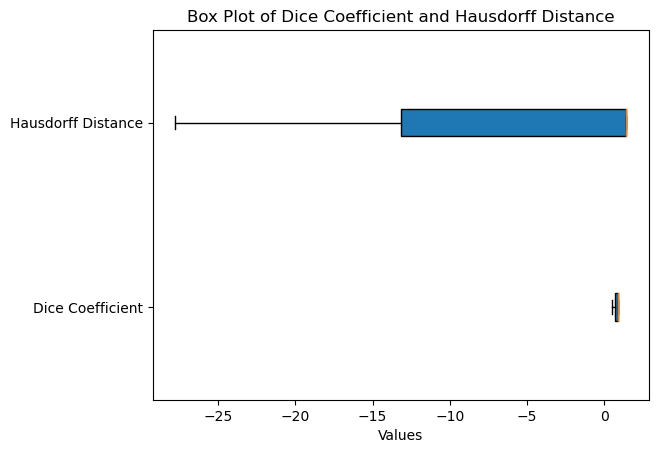

In [32]:
import matplotlib.pyplot as plt

# Dice coefficient statistics
dice_stats = [dice_mean, dice_std, dice_median, dice_25th_percentile, dice_75th_percentile]

# Hausdorff distance statistics
hausdorff_stats = [hausdorff_mean, hausdorff_std, hausdorff_median, hausdorff_25th_percentile, hausdorff_75th_percentile]

# Data for box plots
data = [dice_values, hausdorff_values]

# Plot box plots
fig, ax = plt.subplots()

# Creating box plot
ax.boxplot(data, vert=False, patch_artist=True, labels=['Dice Coefficient', 'Hausdorff Distance'])

# Set title and labels
ax.set_title('Box Plot of Dice Coefficient and Hausdorff Distance')
ax.set_xlabel('Values')

# Display the plot
plt.show()


In [33]:
# Define height and width of the masks
height = 256
width  = 256

# Define Dice coefficient and Hausdorff distance arrays for each class
dice_wt_values = []
dice_tc_values = []
dice_et_values = []

hausdorff_wt_values = []
hausdorff_tc_values = []
hausdorff_et_values = []

# Number of samples
num_samples = 50

# Loop over the samples
for _ in range(num_samples):
    # Pred masks: [ET, NCR, ED]
    pred_masks = np.random.randint(0, 2, size = (3, height, width))

    # True masks: [ET, NCR, ED]
    true_masks = np.random.randint(0, 2, size = (3, height, width))

    # Whole Tumor (WT)
    dice_wt      = dice_coefficient(pred_masks.sum(axis = 0) > 0,   true_masks.sum(axis = 0) > 0)
    hausdorff_wt = hausdorff_distance(pred_masks.sum(axis = 0) > 0, true_masks.sum(axis = 0) > 0)

    # Tumor Core (TC)
    dice_tc      = dice_coefficient(pred_masks[[0, 1, 2]].sum(axis = 0) > 0,   true_masks[[0, 1, 2]].sum(axis = 0) > 0)
    hausdorff_tc = hausdorff_distance(pred_masks[[0, 1, 2]].sum(axis = 0) > 0, true_masks[[0, 1, 2]].sum(axis = 0) > 0)

    # Enhancing Tumor (ET)
    dice_et      = dice_coefficient(pred_masks[0] > 0,    true_masks[0] > 0)
    hausdorff_et = hausdorff_distance(pred_masks[0] > 0, true_masks[0] > 0)

    # Append values to respective arrays
    dice_wt_values.append(dice_wt)
    dice_tc_values.append(dice_tc)
    dice_et_values.append(dice_et)

    hausdorff_wt_values.append(hausdorff_wt)
    hausdorff_tc_values.append(hausdorff_tc)
    hausdorff_et_values.append(hausdorff_et)



In [34]:
# Calculate statistics for Dice coefficients
dice_wt_mean = np.mean(dice_wt_values)
dice_tc_mean = np.mean(dice_tc_values)
dice_et_mean = np.mean(dice_et_values)

dice_wt_std = np.std(dice_wt_values)
dice_tc_std = np.std(dice_tc_values)
dice_et_std = np.std(dice_et_values)

dice_wt_median = np.median(dice_wt_values)
dice_tc_median = np.median(dice_tc_values)
dice_et_median = np.median(dice_et_values)

dice_wt_25th_percentile = np.percentile(dice_wt_values, 25)
dice_tc_25th_percentile = np.percentile(dice_tc_values, 25)
dice_et_25th_percentile = np.percentile(dice_et_values, 25)

dice_wt_75th_percentile = np.percentile(dice_wt_values, 75)
dice_tc_75th_percentile = np.percentile(dice_tc_values, 75)
dice_et_75th_percentile = np.percentile(dice_et_values, 75)



In [35]:
# Calculate statistics for Hausdorff distances
hausdorff_wt_mean = np.mean(hausdorff_wt_values)
hausdorff_tc_mean = np.mean(hausdorff_tc_values)
hausdorff_et_mean = np.mean(hausdorff_et_values)

hausdorff_wt_std = np.std(hausdorff_wt_values)
hausdorff_tc_std = np.std(hausdorff_tc_values)
hausdorff_et_std = np.std(hausdorff_et_values)

hausdorff_wt_median = np.median(hausdorff_wt_values)
hausdorff_tc_median = np.median(hausdorff_tc_values)
hausdorff_et_median = np.median(hausdorff_et_values)

hausdorff_wt_25th_percentile = np.percentile(hausdorff_wt_values, 25)
hausdorff_tc_25th_percentile = np.percentile(hausdorff_tc_values, 25)
hausdorff_et_25th_percentile = np.percentile(hausdorff_et_values, 25)

hausdorff_wt_75th_percentile = np.percentile(hausdorff_wt_values, 75)
hausdorff_tc_75th_percentile = np.percentile(hausdorff_tc_values, 75)
hausdorff_et_75th_percentile = np.percentile(hausdorff_et_values, 75)



In [36]:
# Print the statistics
print("Dice Coefficient Statistics:")
print("Whole Tumor (WT):")
print("Mean:", dice_wt_mean)
print("STD Dev:", dice_wt_std)
print("Median:", dice_wt_median)
print("25th Percentile:", dice_wt_25th_percentile)
print("75th Percentile:", dice_wt_75th_percentile)

print("\nTumor Core (TC):")
print("Mean:", dice_tc_mean)
print("STD Dev:", dice_tc_std)
print("Median:", dice_tc_median)
print("25th Percentile:", dice_tc_25th_percentile)
print("75th Percentile:", dice_tc_75th_percentile)

print("\nEnhancing Tumor (ET):")
print("Mean:", dice_et_mean)
print("STD Dev:", dice_et_std)
print("Median:", dice_et_median)
print("25th Percentile:", dice_et_25th_percentile)
print("75th Percentile:", dice_et_75th_percentile)



Dice Coefficient Statistics:
Whole Tumor (WT):
Mean: 0.8746206390659207
STD Dev: 0.0010715677910807858
Median: 0.8744912071535971
25th Percentile: 0.8739114239688052
75th Percentile: 0.8753438410760654

Tumor Core (TC):
Mean: 0.8746206390659207
STD Dev: 0.0010715677910807858
Median: 0.8744912071535971
25th Percentile: 0.8739114239688052
75th Percentile: 0.8753438410760654

Enhancing Tumor (ET):
Mean: 0.49990651494764266
STD Dev: 0.0021908962140450533
Median: 0.5000950069854992
25th Percentile: 0.4982174611620257
75th Percentile: 0.5013645651380676


In [37]:
print("\nHausdorff Distance Statistics:")
print("Whole Tumor (WT):")
print("Mean:", hausdorff_wt_mean)
print("STD Dev:", hausdorff_wt_std)
print("Median:", hausdorff_wt_median)
print("25th Percentile:", hausdorff_wt_25th_percentile)
print("75th Percentile:", hausdorff_wt_75th_percentile)

print("\nTumor Core (TC):")
print("Mean:", hausdorff_tc_mean)
print("STD Dev:", hausdorff_tc_std)
print("Median:", hausdorff_tc_median)
print("25th Percentile:", hausdorff_tc_25th_percentile)
print("75th Percentile:", hausdorff_tc_75th_percentile)

print("\nEnhancing Tumor (ET):")
print("Mean:", hausdorff_et_mean)
print("STD Dev:", hausdorff_et_std)
print("Median:", hausdorff_et_median)
print("25th Percentile:", hausdorff_et_25th_percentile)
print("75th Percentile:", hausdorff_et_75th_percentile)



Hausdorff Distance Statistics:
Whole Tumor (WT):
Mean: 1.3645079348883236
STD Dev: 0.1346034755376039
Median: 1.4142135623730951
25th Percentile: 1.4142135623730951
75th Percentile: 1.4142135623730951

Tumor Core (TC):
Mean: 1.3645079348883236
STD Dev: 0.1346034755376039
Median: 1.4142135623730951
25th Percentile: 1.4142135623730951
75th Percentile: 1.4142135623730951

Enhancing Tumor (ET):
Mean: 2.2782865370430176
STD Dev: 0.17149476705875089
Median: 2.23606797749979
25th Percentile: 2.23606797749979
75th Percentile: 2.23606797749979


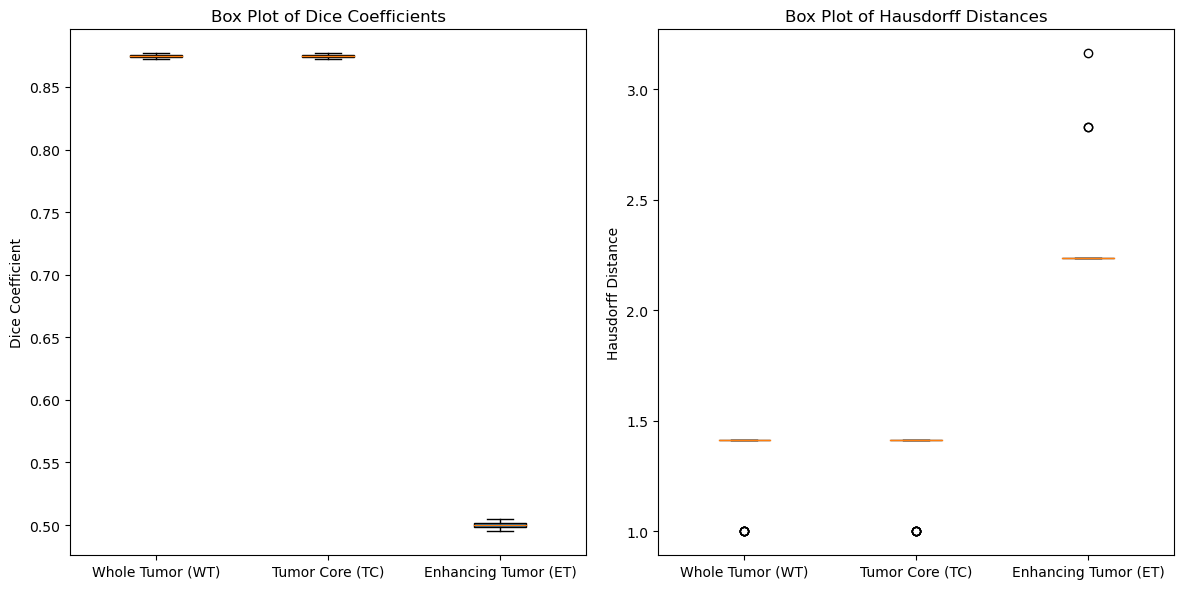

In [38]:
import matplotlib.pyplot as plt

# Data for box plots
dice_data = [dice_wt_values, dice_tc_values, dice_et_values]
hausdorff_data = [hausdorff_wt_values, hausdorff_tc_values, hausdorff_et_values]

# Plot box plots for Dice coefficients
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(dice_data, patch_artist=True, labels=['Whole Tumor (WT)', 'Tumor Core (TC)', 'Enhancing Tumor (ET)'])
plt.title('Box Plot of Dice Coefficients')
plt.ylabel('Dice Coefficient')

# Plot box plots for Hausdorff distances
plt.subplot(1, 2, 2)
plt.boxplot(hausdorff_data, patch_artist=True, labels=['Whole Tumor (WT)', 'Tumor Core (TC)', 'Enhancing Tumor (ET)'])
plt.title('Box Plot of Hausdorff Distances')
plt.ylabel('Hausdorff Distance')

# Display the plots
plt.tight_layout()
plt.show()


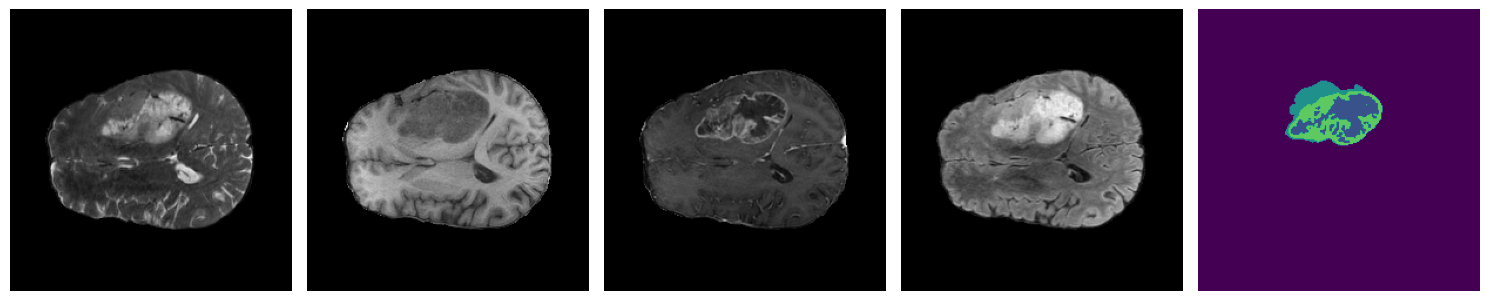

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

imgs = [nib.load(f"D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/BraTS-GoAT-00003/BraTS-GoAT-00003-{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["t2w", "t1n", "t1c", "t2f"]]
lbl  = nib.load("D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth/BraTS-GoAT-00003/BraTS-GoAT-00003-seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap = 'gray')
    ax[i].axis('off')
ax[-1].imshow(lbl, vmin = 0, vmax = 4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

In [32]:
import os
import json
import nibabel as nib
import numpy as np
from glob import glob
from joblib import Parallel, delayed

def load_nifty(directory, example_id, suffix):
    return nib.load(os.path.join(directory, example_id + "-" + suffix + ".nii.gz"))

def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)

def prepare_nifty(d):
    example_id = d.split(os.sep)[-1]
    flair, t1, t1ce, t2 = [load_nifty(d, example_id, suffix) for suffix in ["t2w", "t1n", "t1c", "t2f"]]
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nib.Nifti1Image(vol, flair.affine, header=flair.header)
    nib.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "-seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        vol = get_data(seg, "uint8")
        vol[vol == 4] = 3
        seg = nib.Nifti1Image(vol, seg.affine, header=seg.header)
        nib.save(seg, os.path.join(d, example_id + "-seg.nii.gz"))

def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "imagesTr" if train else "imagesTs"), os.path.join(data, "labelsTr")
    os.makedirs(img_path, exist_ok=True)
    if train:
        os.makedirs(lbl_path, exist_ok=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if os.path.isdir(d):
            example_id = os.path.basename(d)
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "seg" in f:
                    shutil.move(f, os.path.join(lbl_path, os.path.basename(f)))
                else:
                    shutil.move(f, os.path.join(img_path, os.path.basename(f)))
            os.rmdir(d)

def prepare_dataset_json(data, train):
    img_dir, lbl_dir = os.path.join(data, "imagesTr" if train else "imagesTs"), os.path.join(data, "labelsTr")
    images = sorted([os.path.join("imagesTr" if train else "imagesTs", os.path.basename(f)) for f in glob(os.path.join(img_dir, "*.nii.gz"))])
    labels = sorted([os.path.join("labelsTr", os.path.basename(f)) for f in glob(os.path.join(lbl_dir, "*.nii.gz"))]) if train else []
    
    dataset = {
        "name": "BraTS",
        "description": "Brain Tumor Segmentation",
        "tensorImageSize": "4D",
        "reference": "nnU-Net",
        "licence": "CC-BY-SA 4.0",
        "release": "0.0",
        "modality": {
            "0": "FLAIR",
            "1": "T1",
            "2": "T1CE",
            "3": "T2"
        },
        "labels": {
            "0": "background",
            "1": "edema",
            "2": "non-enhancing tumor",
            "3": "enhancing tumor"
        },
        "numTraining": len(images) if train else 0,
        "numTest": 0 if train else len(images),
        "training": [{"image": img, "label": lbl} for img, lbl in zip(images, labels)] if train else [],
        "test": [{"image": img} for img in images] if not train else []
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile, indent=4)

def prepare_dataset(data, train=True):
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)

# Set your data path here
DATA_PATH = "D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-TrainingData-With-GroundTruth"

# Prepare training and validation datasets
prepare_dataset(os.path.join(DATA_PATH, "train"), train=True)
prepare_dataset(os.path.join(DATA_PATH, "val"), train=False)

print("Dataset preparation completed!")


Dataset preparation completed!


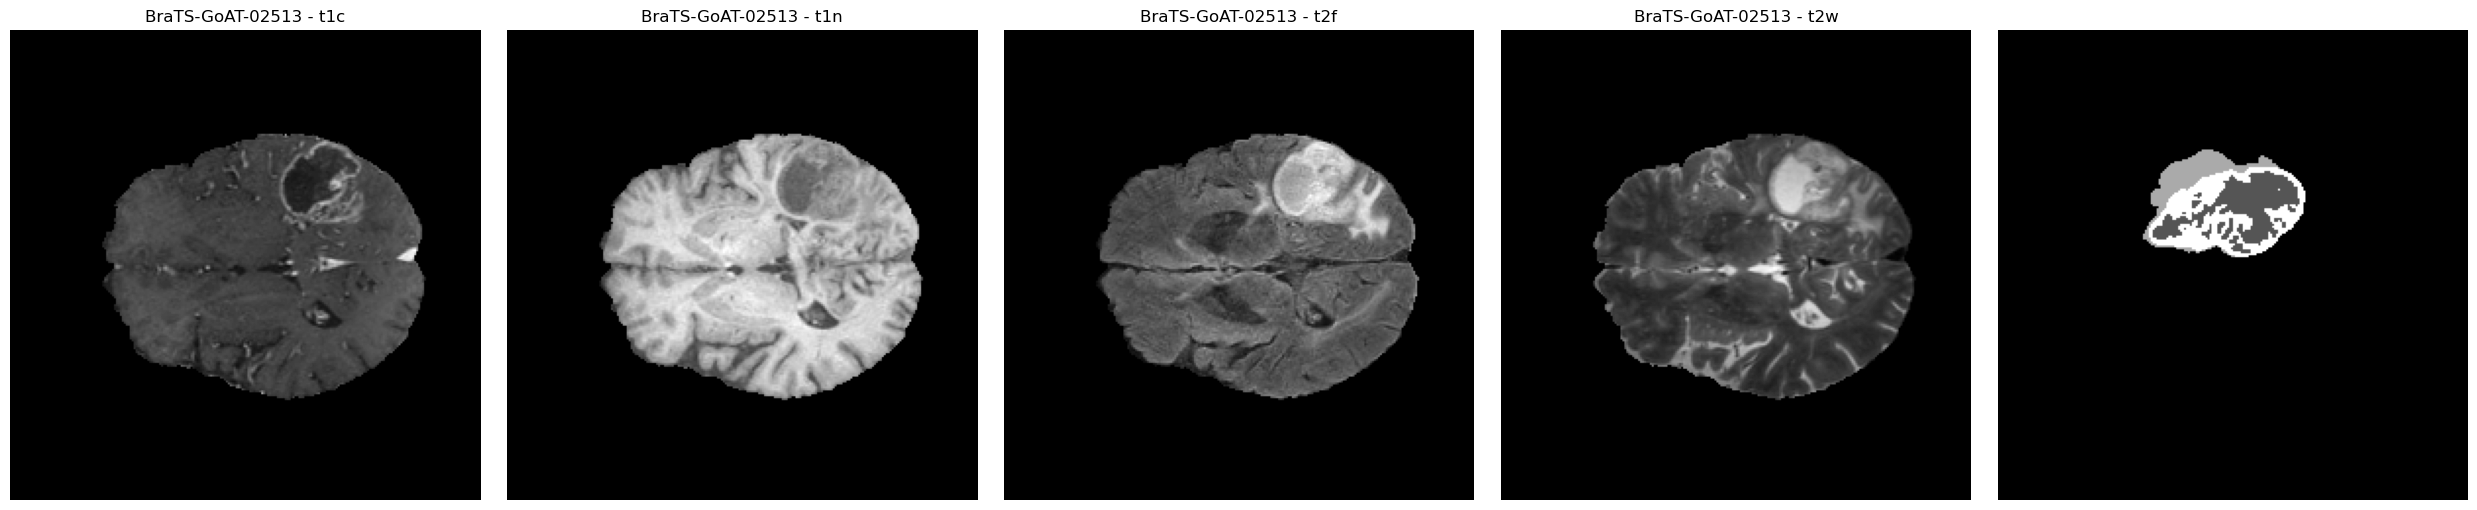

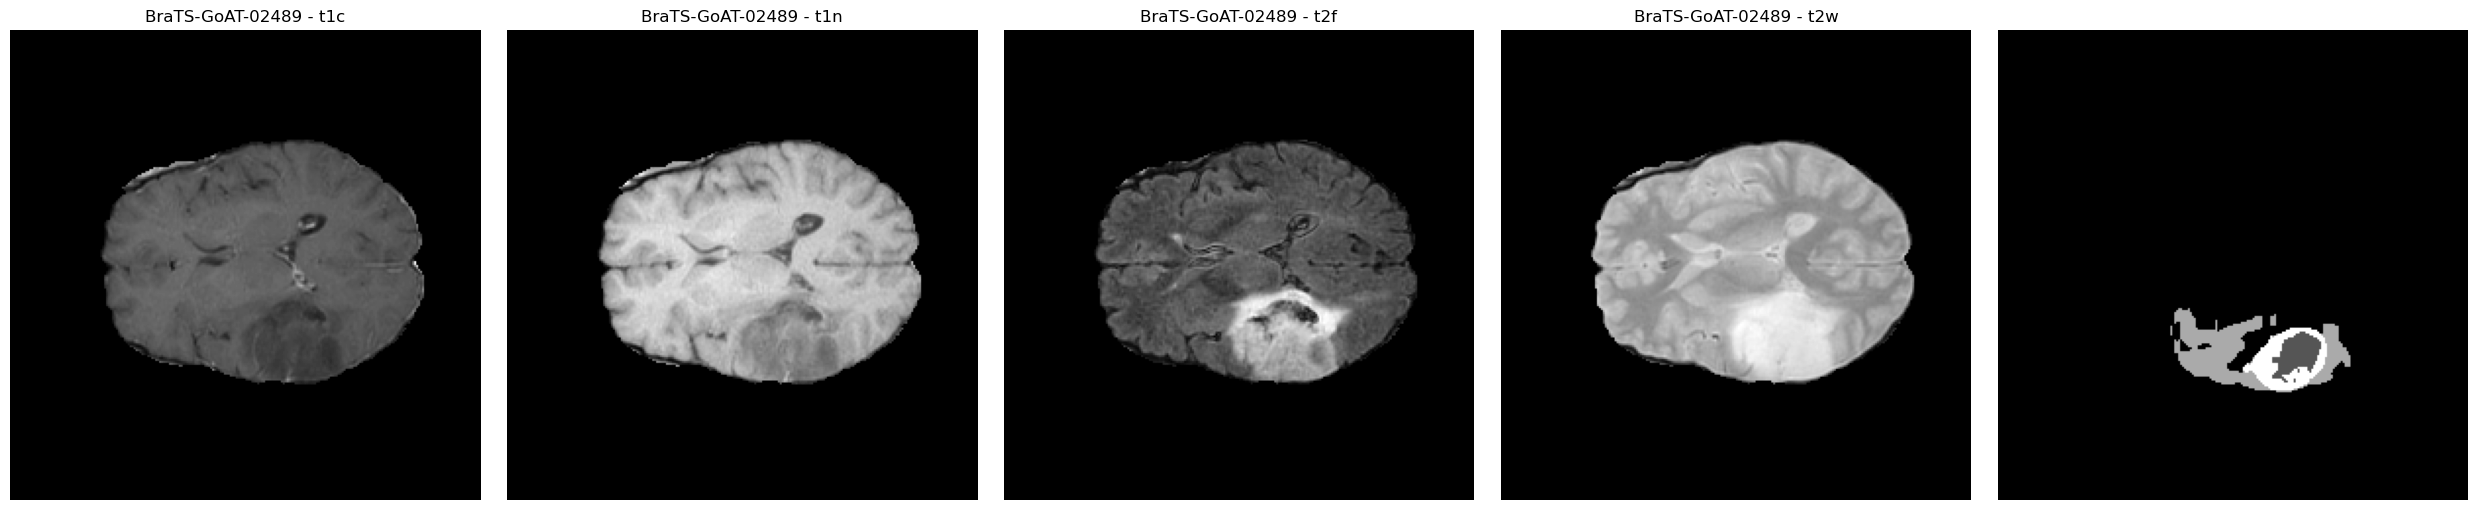

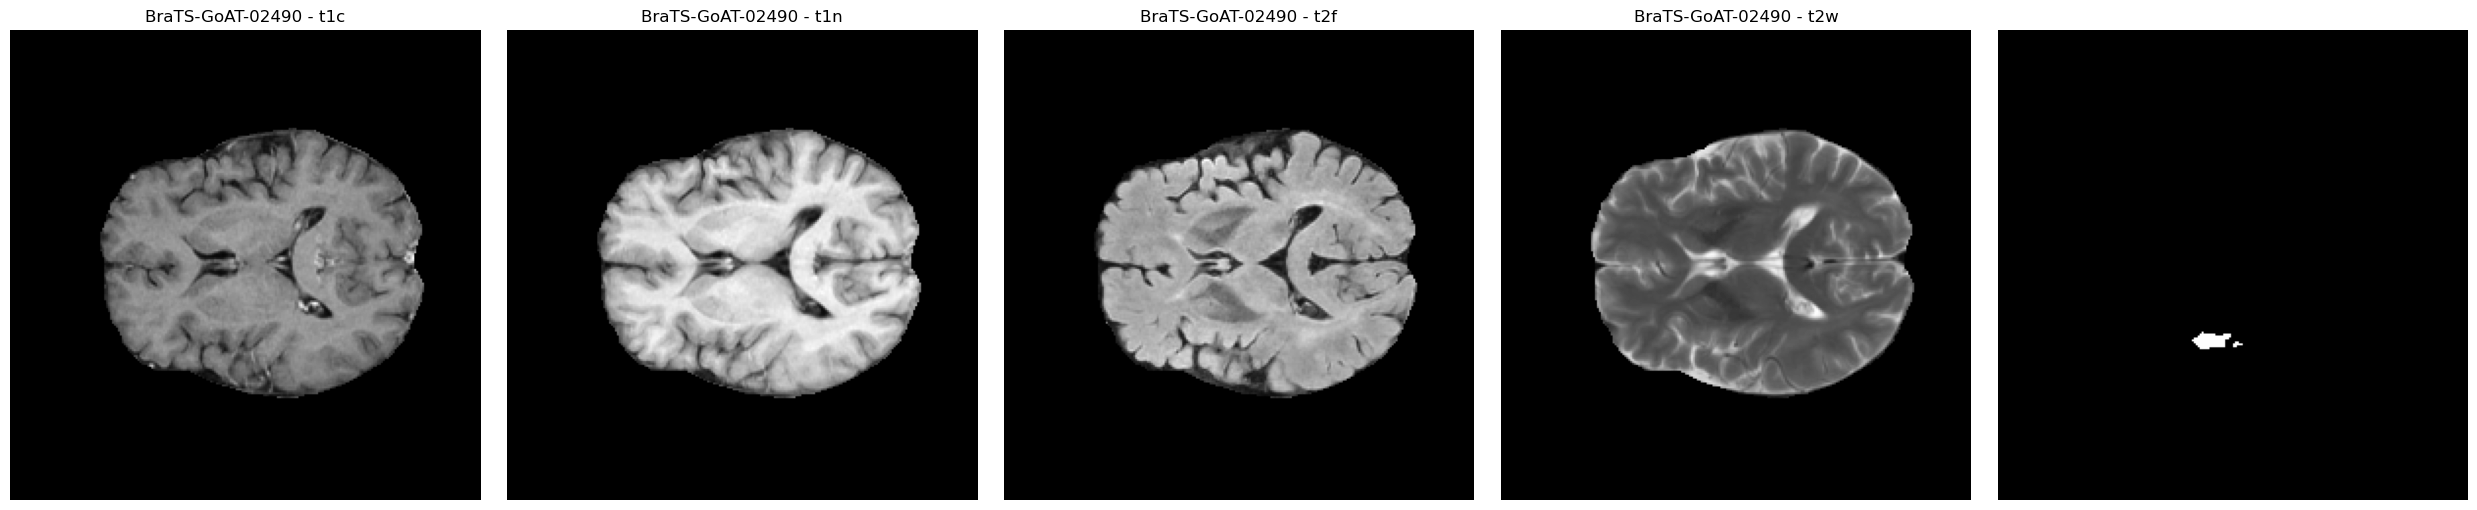

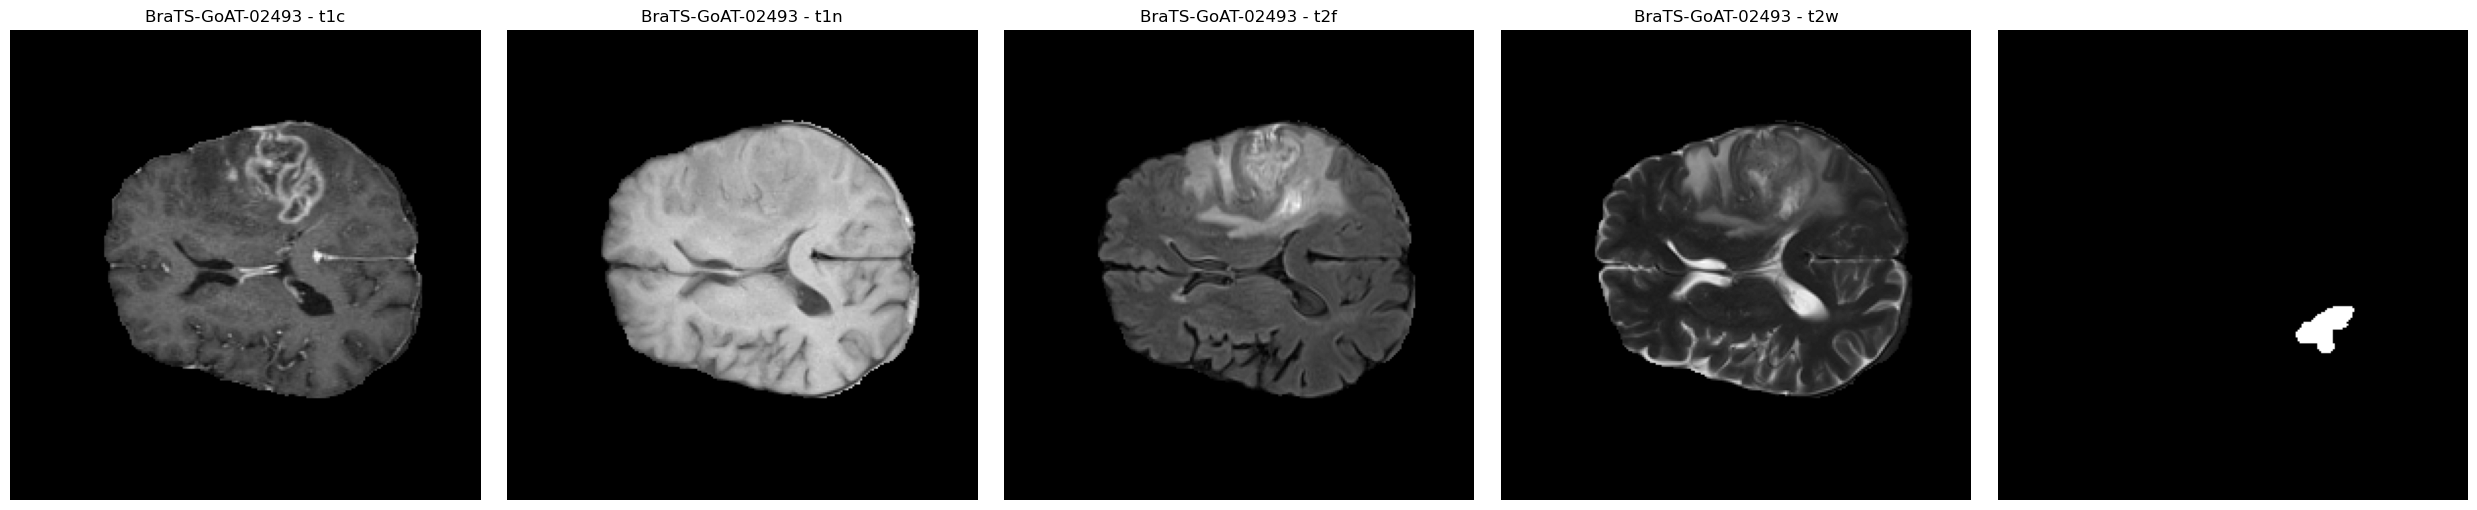

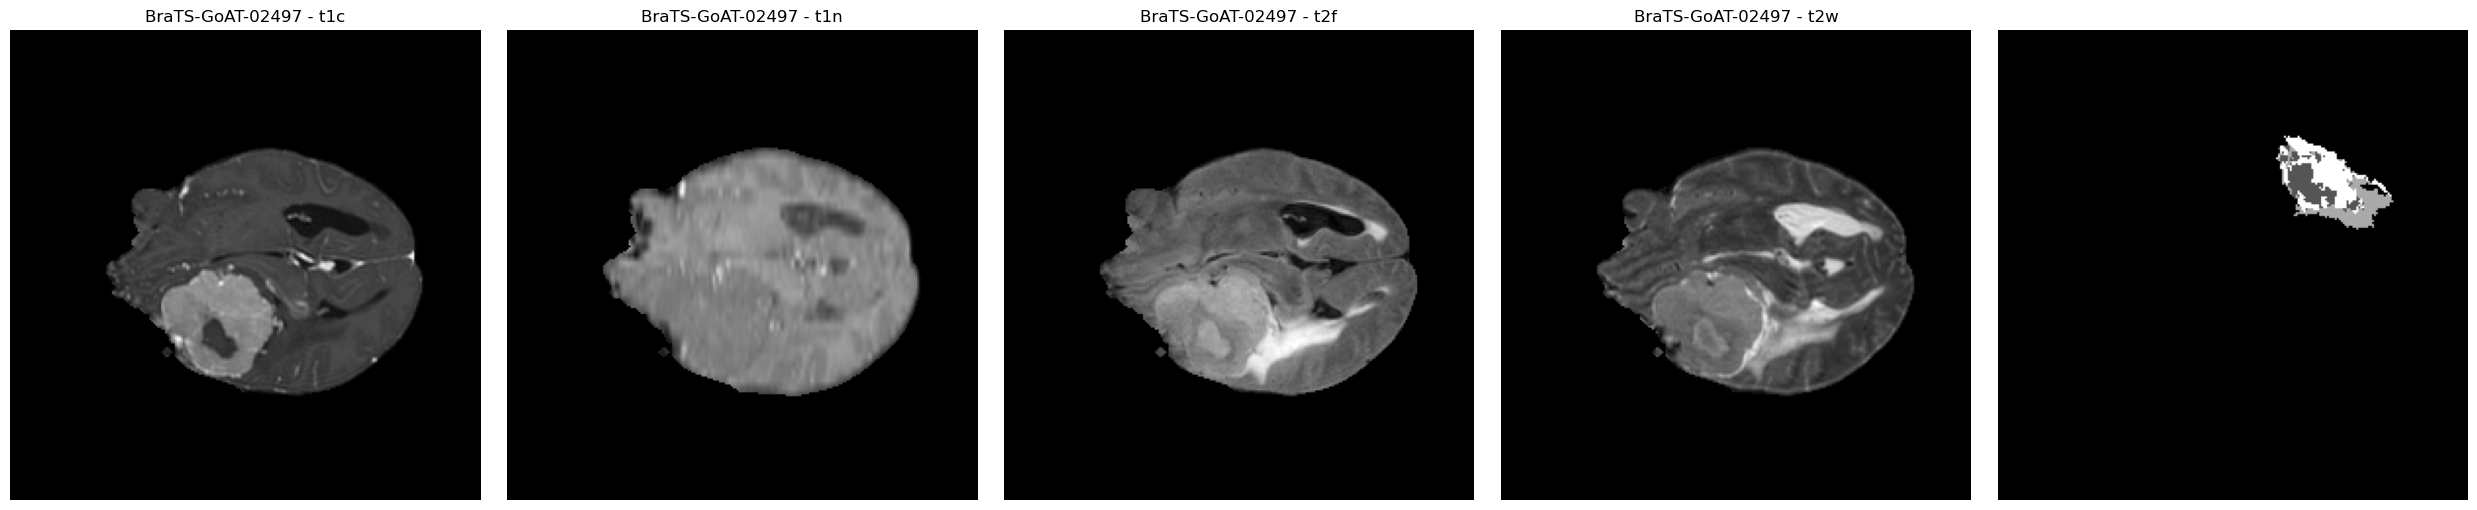

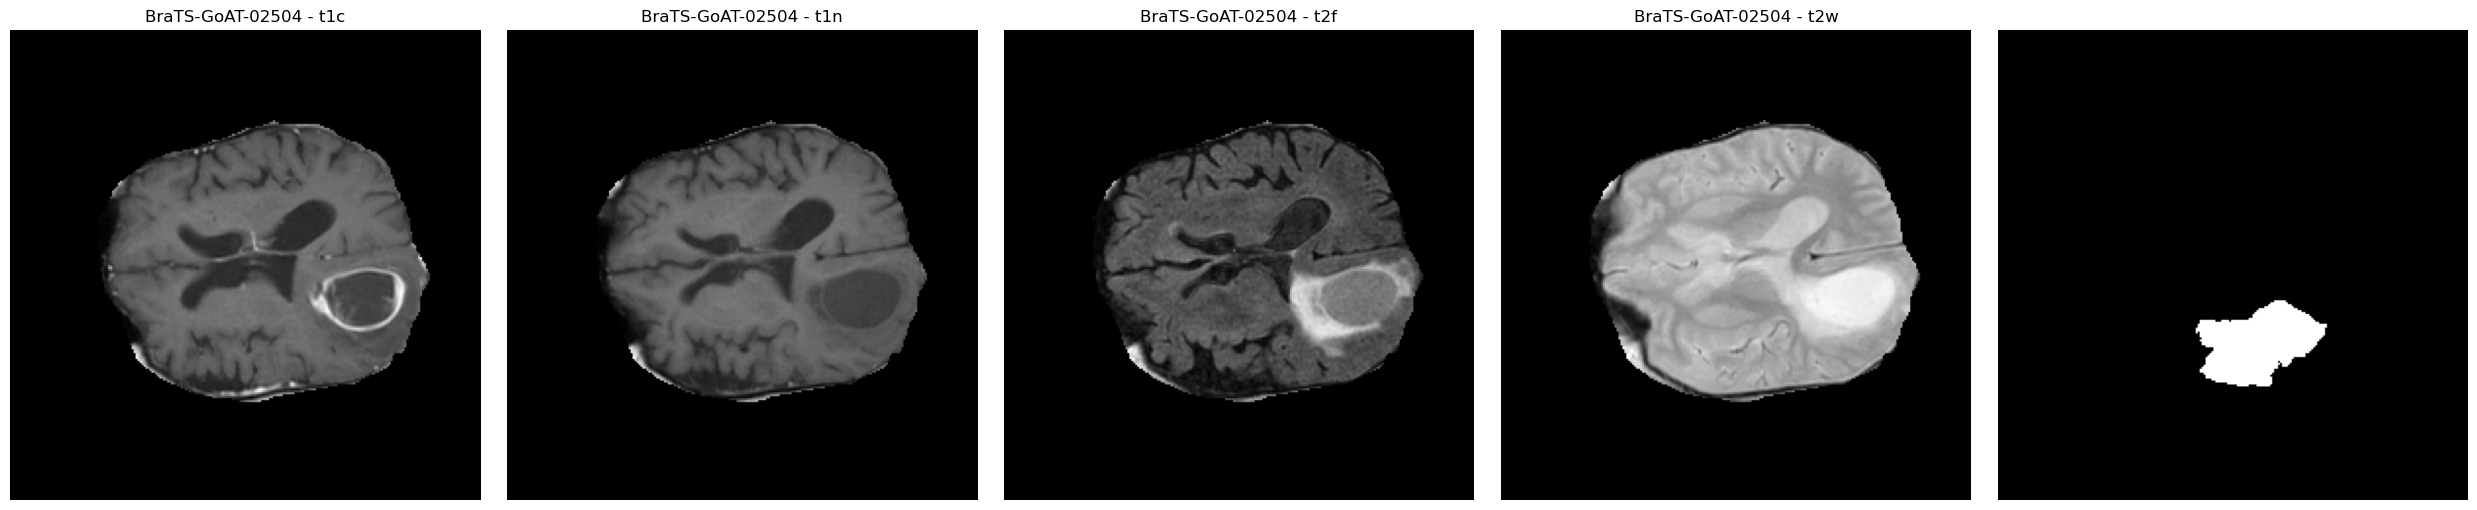

In [5]:


import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Load the model
model = load_model('brain_segmentation_model.h5')

# Function to create the directory if it doesn't exist
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Function to load NIfTI images 
def load_nii_images_and_labels(folder_path, slice_num=75):
    img_paths = [os.path.join(folder_path, f'{os.path.basename(folder_path)}-{m}.nii.gz') for m in ["t2w", "t1n", "t1c", "t2f"]]
    imgs = [nib.load(img_path).get_fdata().astype(np.float32)[:, :, slice_num] for img_path in img_paths]
    
    # Combine image channels
    combined_img = np.stack(imgs, axis=-1)
    
    return np.array([combined_img]), img_paths

# Paths to the main directories
validation_base_dir = 'D:/Shivank/BraTS_Brain_Segmentation/MICCAI2024-BraTS-GoAT-ValidationData/MICCAI2024-BraTS-GoAT-ValidationData/'

# Directory to save the segmentation images
save_dir = 'D:/Shivank/BraTS_Brain_Segmentation/Segmentation_Results/'
create_dir(save_dir)

# Iterate through each validation folder
for validation_folder, training_folder in folder.items():
    validation_folder_path = os.path.join(validation_base_dir, validation_folder)

    
    # Load the validation images
    images, image_paths = load_nii_images_and_labels(validation_folder_path)
    
    # Normalize images
    images = images / 255.0

    # Predict the segmentation masks
    predictions = model.predict(images)

    # Load the segmentation image from the training folder
    segmentation_file_path = os.path.join(training_folder_path, f"{training_folder}-seg.nii.gz")
    segmentation_image = nib.load(segmentation_file_path).get_fdata().astype(np.uint8)[:, :, 75]
    
    # Save the segmentation image
    seg_save_path = os.path.join(save_dir, f"{validation_folder}-seg.nii.gz")
    nib.save(nib.Nifti1Image(segmentation_image, np.eye(4)), seg_save_path)
    
    # Create a plot for the images
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    for i, img in enumerate(images[0]):
        ax[i].imshow(img[:, :, 0], cmap='gray')
        ax[i].set_title(f"{validation_folder} - {['t2w', 't1n'][i]}")
        ax[i].axis('off')
    ax[4].imshow(segmentation_image, cmap='gray')
    ax[4].axis('off')
    plt.tight_layout()
    plt.show()


